In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import torchvision
import json
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from random import randrange
import cv2

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(image_dir))))
        with open(annotation_path) as json_file:
            annotation_list = json.load(json_file)
        self.annotation_list = annotation_list

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        label_bbox = self.annotation_list[idx]['bbox']
        img = read_image(img_path).numpy().transpose(1, 2, 0) # Convert CHW to HWC format for albumentations
        # Pascal VOC / original annotation is COCO
        boxes = [[label_bbox[0], label_bbox[1], label_bbox[0]+label_bbox[2], label_bbox[1]+label_bbox[3]]]  # In a list for albumentations
        category = [self.annotation_list[idx]['category_id']]  # In a list for albumentations

        if self.transforms:
            transformed = self.transforms(image=img, bboxes=boxes, labels=category)
            img = transformed["image"]
            boxes = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
            category = torch.as_tensor(transformed["labels"], dtype=torch.int8)

        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = boxes
        target["category"] = category
        target["image_id"] = image_id
        
        return img, target

    def __len__(self):
        return len(self.imgs)

def get_transforms():
    return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.25),
            A.Rotate(limit=25, p=0.75),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [2]:
train_dataset = CustomImageDataset('./images/train', annotation_path="./images/train_annotations", transforms=get_transforms())

In [3]:
category_dict = {1:"penguin", 2:"turtle"}

In [4]:
number = randrange(len(train_dataset)+1)
image, target = train_dataset[number]

In [5]:
image.shape

torch.Size([3, 640, 640])

In [6]:
bbox = target['boxes'][0]

In [7]:
bbox

tensor([  0.0000, 113.1949, 385.2560, 456.7968])

In [8]:
target

{'boxes': tensor([[  0.0000, 113.1949, 385.2560, 456.7968]]),
 'category': tensor([2], dtype=torch.int8),
 'image_id': tensor([361])}

In [9]:
image_np = image.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

In [10]:
category = category_dict[int(target["category"])]

In [11]:
start = (int(bbox[0]) ,int(bbox[1]))
end = (int(bbox[2]), int(bbox[3]))
color = (255, 0, 0)
thickness = 5
cv2.rectangle(image_np, start, end, color, thickness)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [12]:
id = str(int(target["image_id"])).zfill(3)

In [13]:
original_img =cv2.imread('./images/train/image_id_'+ id +'.jpg')
#cv2.rectangle(original_img, start, end, color, thickness)

(-0.5, 639.5, 639.5, -0.5)

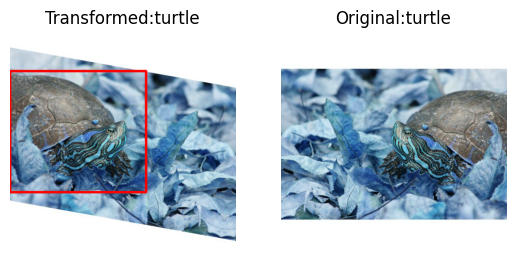

In [14]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_np) 
axes[0].set_title("Transformed:" + category)
axes[0].axis('off')
axes[1].imshow(original_img) 
axes[1].set_title("Original:" + category)
axes[1].axis('off')

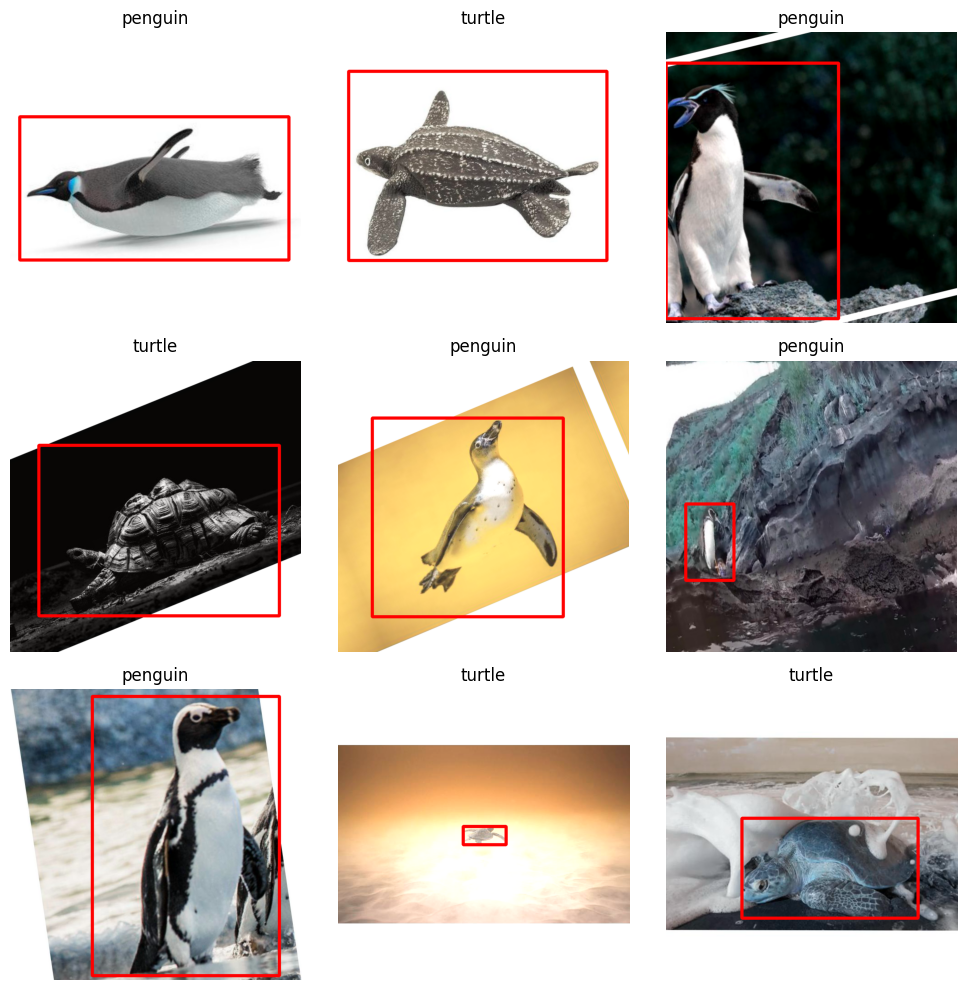

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        # random index
        number = randrange(len(train_dataset)+1)
        image, target = train_dataset[number]
        bbox = target['boxes'][0]
        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        category = category_dict[int(target["category"])]
        start = (int(bbox[0]) ,int(bbox[1]))
        end = (int(bbox[2]), int(bbox[3]))
        color = (255, 0, 0)
        thickness = 5
        # draw bbox
        cv2.rectangle(image_np, start, end, color, thickness)
        # display
        axes[i, j].imshow(image_np)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()